In [1]:
import os
os.environ['PYTHONHASHSEED'] = '0'
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

# Biblioteca para identificar os sinais, os indices dos complexos QRS e
# as anotacoes nos bancos de dados do MIT
import wfdb
from wfdb import processing

import math
import pywt
import pandas as pd
import numpy as np
from numpy import *
from numpy import load
import scipy.io as sio
import numpy.matlib 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from scipy import signal
from os import listdir
from numpy.linalg import inv,pinv
from numpy.linalg import eig

from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.interpolate import interp1d
from sklearn import covariance
from sklearn.utils import class_weight

import datetime
import json
import seaborn as sn
import pandas as pd

# Importacao do arquivo contendo funcoes de pre-processamento,
# segmentacao e divisao do banco de dados
import import_ipynb
from SeparacaoAAMI import *

# Fixando as seeds
import random
random.seed(21)
np.random.seed(21)
seed_value= 3016
tf.random.set_seed(seed_value)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

%matplotlib inline

importing Jupyter notebook from SeparacaoAAMI.ipynb


In [3]:
fs = 360 # Freq. de amostragem do sinal
pasta = 'mit-bih-arrhythmia-database-1.0.0/'

# Divisao seguindo Chazal et al. (2004)
DS1 = ['101', '106', '108', '109', '112', '114', '115', '116', '118', '119', '122', '124', '201', '203', '205', '207', '208', '209', '215', '220', '223', '230']
DS2 = ['100', '103', '105', '111', '113', '117', '121', '123', '200', '202', '210', '212', '213', '214', '219', '221', '222', '228', '231', '232', '233', '234']

# Divisao dos dados nas classes da AAMI
N = ['N', 'L', 'R', 'e', 'j']
S = ['A', 'a', 'J', 'S']
V = ['V', 'E']
F = ['F']
Q = ['/', 'f', 'Q']
nonbeat = ['[', ']', '!', 'x', '|', '~', '+', '"'] #nao pertencem a nenhuma das classes

# Importacao das localizacoes dos complexos QRS corrigidas, ou seja,
# das localizacoes seguindo as anotacoes, dados os simbolos que foram
# identificados pelo ecg-kit (MATLAB)

with open('simbolos_versaofinal.json', 'r') as json_file:
    simbolos = json.load(json_file)

In [4]:
periodo = 320 # numero aproximado de amostras em um batimento 

# Modo de entrada para obter tanto as 960 amostras do sinal quanto as
# caracteristicas extraidas seguindo Chazal
modo = 'MI' 

# Sem normalizacao do sinal
norm = False

# Mother-wavelet e nivel de decomposicao
wavFunc = 'db2'
level = 4

# Numero de classes do problema e numero de blocos LSTM (se for uma rede RNN)
numclass = 4

# Divisao dos pacientes em dados de treinamento e dados de teste
# da primeira derivacao (indice 0) e da segunda derivacao (indice 1).
# X_train0_all corresponde a todo o numero de dados disponivel da
# primeira derivacao para o treinamento. X_train0_all_chazal corresponde
# a todo o numero de dados disponivel das caracteristicas extraidas,
# seguindo Chazal, da primeira derivacao para o treinamento. 
# Y_train_int_all representa as classes verdadeiras dos dados, em inteiros 
# (k = 0 corresponde a classe N, k = 1 corresponde a classe S...).
# Sym_train contem os simbolos dos batimentos de treinamento e
# Patient_train contem os pacientes em que eles ocorrem.

X_train0_all, X_train1_all, X_train0_all_chazal, X_train1_all_chazal, Y_train_int_all, Sym_train, Patient_train = dataset(pasta, DS1, periodo, fs, simbolos, modo, norm, wavFunc, level,'NSVF',0)
X_test0_all, X_test1_all, X_test0_all_chazal, X_test1_all_chazal, Y_test_int_all, Sym_test, Patient_test = dataset(pasta, DS2, periodo, fs, simbolos, modo, norm, wavFunc, level, 'NSVF',0)

# X_train0_all, X_train1_all, Y_train_int_all, Sym_train, Patient_train = datasetNSVF(pasta, DS1, periodo, fs, simbolos, modo, norm, wavFunc, level)
# X_test0_all, X_test1_all, Y_test_int_all, Sym_test, Patient_test = datasetNSVF(pasta, DS2, periodo, fs, simbolos, modo, norm, wavFunc, level)

In [5]:
def eq_dataset(df, DS, numclass):
    # Funcao para selecionar aleatoriamente, mas respeitando
    # a divisao dos pacientes, os dados de cada classe de modo 
    # a equilibrar a quantidade de exemplos em cada. Nao corresponde
    # a uma boa selecao de entrada no cenario realista, pois reduz muito o numero
    # de dados disponiveis, sendo usada somente para testes e para 
    # verificar problemas que nao sao associados ao desbalanceamento.
    # Foi feita de modo que nenhum paciente fosse excluido e que batimentos
    # selecionados de um mesmo paciente nao fossem consecutivos.
    # Retorna o indice dos dados selecionados.
    num = 372
    num_pat = len(DS) #numero de pacientes
    ind_eq = []
    for i in DS:
        for j in range(numclass):
            ind = df.index[(df['Y'] == j) & (df['Paciente'] == i)].tolist()
            if (size(ind) > 0) and isin(j, [3]):
                ind_eq = np.concatenate([ind_eq, ind])
            elif (size(ind) > 0) and isin(j, [0]):
                ind_eq = np.concatenate([ind_eq, random.sample(ind, int(np.floor(num/(num_pat))))])
            elif (size(ind) > 0) and (isin(j, [2])) and (size(ind) > 8*int(np.floor(num/num_pat))):
                ind_eq = np.concatenate([ind_eq, random.sample(ind, int(np.floor(num/(num_pat*1.4))))])
            elif (size(ind) > 0) and (size(ind) > 12*int(np.floor(num/num_pat))):
                ind_eq = np.concatenate([ind_eq, random.sample(ind, int(np.floor(num/(num_pat*1.1))))])
            elif (size(ind) > 0):
                ind_eq = np.concatenate([ind_eq, ind])

    return ind_eq

def dim_N_dataset(df, DS, numclass):
    # Funcao para selecionar os dados usando todos os exemplos das classes
    # S, V, F e Q, e diminuindo o numero de dados da classe N.
    # Foi feita de modo que nenhum paciente fosse excluido e que batimentos
    # selecionados de um mesmo paciente nao fossem consecutivos.
    # Retorna o indice dos dados selecionados.
    num = 8500
    num_pat = len(DS) #numero de pacientes
    ind_eq = []
    for i in DS:
        for j in range(numclass):
            ind = df.index[(df['Y'] == j) & (df['Paciente'] == i)].tolist()
            if (size(ind) > 0) and isin(j, [0]) and (size(ind) > 1.5*int(np.floor(num/num_pat))):
                ind_eq = np.concatenate([ind_eq, random.sample(ind, int(np.floor(num/(num_pat))))])
            elif (size(ind) > 0):
                ind_eq = np.concatenate([ind_eq, ind])

    return ind_eq

#################### Quantidade de dados utilizados ######################
########## Todos as classes com aproximadamente o mesmo numero ###########
# df_train = pd.DataFrame({'Paciente': Patient_train, 'Y': Y_train_int_all.flatten().astype('int32')})
# df_test = pd.DataFrame({'Paciente': Patient_test, 'Y': Y_test_int_all.flatten().astype('int32')})
# ind_train = [int(i) for i in eq_dataset(df_train, DS1, 4)]
# ind_test = [int(i) for i in eq_dataset(df_test, DS2, 4)]
# X_train0, X_train1, Y_train_int = take_ind(ind_train, X_train0_all, X_train1_all, Y_train_int_all)
# X_test0, X_test1, Y_test_int = take_ind(ind_test, X_test0_all, X_test1_all, Y_test_int_all)

###################### Todos os dados disponiveis ####################
# X_train0, X_train1, Y_train_int = X_train0_all, X_train1_all, Y_train_int_all
# X_test0, X_test1, Y_test_int = X_test0_all, X_test1_all, Y_test_int_all

###### Diminuicao dos dados de N e todos os dados disponiveis das outras ########
df_train = pd.DataFrame({'Paciente': Patient_train, 'Y': Y_train_int_all.flatten().astype('int32')})
df_test = pd.DataFrame({'Paciente': Patient_test, 'Y': Y_test_int_all.flatten().astype('int32')})
ind_train = [int(i) for i in dim_N_dataset(df_train, DS1, 4)]
ind_test = [int(i) for i in dim_N_dataset(df_test, DS2, 4)]
X_train0, X_train1, Y_train_int = take_ind(ind_train, X_train0_all, X_train1_all, Y_train_int_all)
X_test0, X_test1, Y_test_int = take_ind(ind_test, X_test0_all, X_test1_all, Y_test_int_all)
X_train0_chazal, X_train1_chazal, Y_train_int = take_ind(ind_train, X_train0_all_chazal, X_train1_all_chazal, Y_train_int_all)
X_test0_chazal, X_test1_chazal, Y_test_int = take_ind(ind_test, X_test0_all_chazal, X_test1_all_chazal, Y_test_int_all)


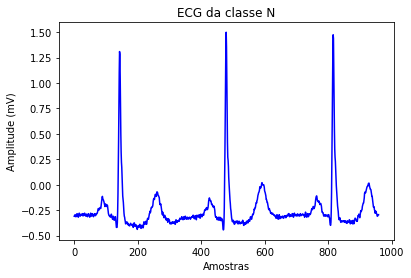

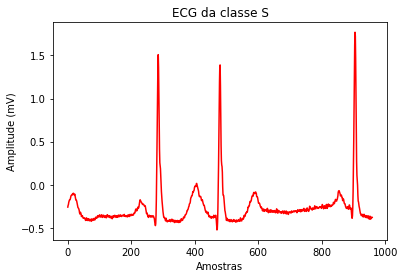

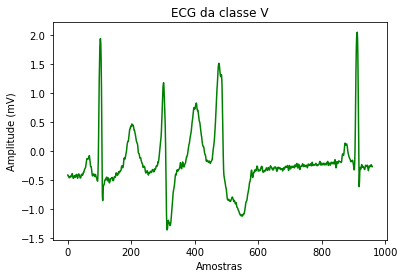

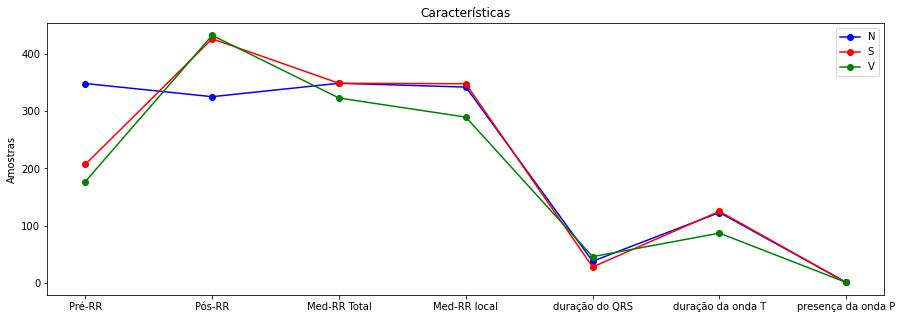

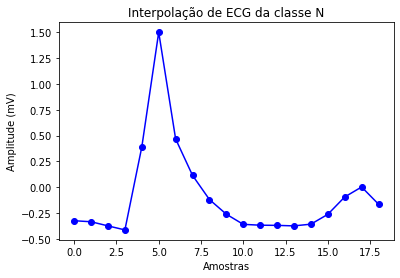

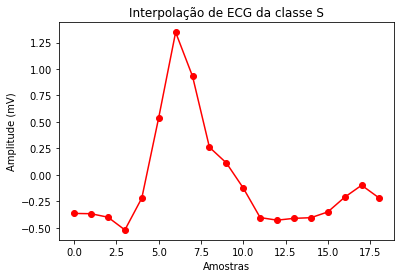

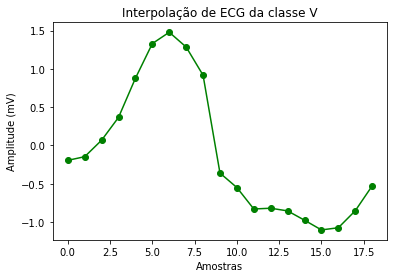

In [6]:
# Plot dos sinais de cada classe
id1 = np.where(Y_train_int == 0)[0][5]
id2 = np.where(Y_train_int == 1)[0][0]
id3 = np.where(Y_train_int == 2)[0][0]
id4 = np.where(Y_train_int == 3)[0][0]
# id5 = np.where(Y_train_int == 4)[0][0]
plt.rcParams.update({'font.size': 10})
# Plot das 3 classes. Plot das 5 classes poderia ser feito com funcao 'plotECG()'
plotECG_NSV(False, X_train0, id1, id2, id3)
plotECG_NSV(True, X_train0_chazal, id1, id2, id3)

In [7]:
# Obtencao dos pesos das classes
Y_train_flat = Y_train_int.flatten()
pesos = class_weight.compute_class_weight(class_weight = 'balanced', classes=np.unique(Y_train_flat),  y=Y_train_flat)
pesos = pesos*10
pesos = list(map(math.ceil,pesos))
pesos = {i: pesos[i] for i in range(np.size(pesos))}

# Codificacao 1 entre m (Classe N, por exemplo, é [1,0,0,0,0])
Y_train = onehot(X_train0, Y_train_int, 4)
Y_test = onehot(X_test0, Y_test_int, 4)
split = X_test0.shape[0]/(X_test0.shape[0] + X_train0.shape[0])

# Mudanca no tamanho dos vetores para tamanho (None,960,1) para trabalhar com a CNN 1D
X_train_CNN0 = np.reshape(X_train0, (X_train0.shape[0], X_train0.shape[1], 1))
X_test_CNN0 = np.reshape(X_test0, (X_test0.shape[0], X_test0.shape[1], 1))
X_train_CNN1 = np.reshape(X_train1, (X_train1.shape[0], X_train1.shape[1], 1))
X_test_CNN1 = np.reshape(X_test1, (X_test1.shape[0], X_test1.shape[1], 1))

# Concatenacao com split para usar dados de teste como validacao e evitar perda de exemplos
all_X0 = np.concatenate((X_train_CNN0, X_test_CNN0), axis = 0)
all_X1 = np.concatenate((X_train_CNN1, X_test_CNN1), axis = 0)
all_label = np.concatenate((Y_train, Y_test), axis = 0)

all_X0.shape

(24266, 960, 1)

In [8]:
# Fixar novamente a seed!
random.seed(21)
np.random.seed(21)
seed_value= 3016
tf.random.set_seed(seed_value)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

# Hiperparametros e Algoritmo de otimizacao
nepochs = 100
adam = tf.keras.optimizers.Adam(learning_rate= 0.001, beta_1=0.9, beta_2=0.99, epsilon=1e-07)
initializer = tf.keras.initializers.GlorotNormal()

# Identificacao do modelo no summary e nas metricas impressas no csv
key = str(datetime.datetime.now())

# Entradas da rede
input0 = layers.Input(shape=(all_X0.shape[1],1))

# Estrutura da CNN
conv1_0 = layers.Conv1D(filters=3, kernel_size=27, strides = 1, padding='valid',kernel_initializer=initializer, activation='relu')(input0)
pool1_0 = layers.MaxPooling1D(pool_size=(2,),strides=2)(conv1_0)
conv2_0 = layers.Conv1D(filters=10, kernel_size=14, padding='valid', activation='relu')(pool1_0)
pool2_0 = layers.MaxPooling1D(pool_size=(2,),strides=2)(conv2_0)
conv3_0 = layers.Conv1D(filters=10, kernel_size=3, padding='valid', activation='relu')(pool2_0)
pool3_0 = layers.MaxPooling1D(pool_size=(2,), strides=2)(conv3_0 )
conv4_0 = layers.Conv1D(filters=10, kernel_size=4, padding='valid', activation='relu')(pool3_0)
pool4_0 = layers.MaxPooling1D(pool_size=(2,), strides=2)(conv4_0)
flat_0 = layers.Flatten()(pool4_0)
hidd1_0 = layers.Dense(30, activation='relu')(flat_0)
drop1_0 = layers.Dropout(0.2)(hidd1_0)
hidd2_0 = layers.Dense(10, activation='relu')(drop1_0)
drop2_0 = layers.Dropout(0.1)(hidd2_0)
output0 = layers.Dense(numclass, activation = 'softmax')(drop2_0)

# Treinamento da rede
model0 = tf.keras.Model(inputs=input0, outputs=output0)
model0.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy', tf.keras.metrics.Recall()])
model0.fit(all_X0, all_label, batch_size=2048, shuffle=True, epochs=nepochs, validation_split=split, verbose = False, class_weight = pesos)
#validationsplit utiliza os ultimos dados de all_X

-------------------------Treino------------------------
[[8305  129   37   21]
 [   0  753    0    0]
 [   5    9 2518    5]
 [   0    0    0  396]]
              precision    recall  f1-score   support

         0.0     0.9994    0.9780    0.9886      8492
         1.0     0.8451    1.0000    0.9161       753
         2.0     0.9855    0.9925    0.9890      2537
         3.0     0.9384    1.0000    0.9682       396

    accuracy                         0.9831     12178
   macro avg     0.9421    0.9926    0.9655     12178
weighted avg     0.9850    0.9831    0.9835     12178

-------------------------Teste------------------------
[[7024  476  588  271]
 [ 851  420   40    8]
 [  42  103 1824   65]
 [  92   14  110  160]]
              precision    recall  f1-score   support

         0.0     0.8770    0.8403    0.8583      8359
         1.0     0.4146    0.3184    0.3602      1319
         2.0     0.7119    0.8968    0.7937      2034
         3.0     0.3175    0.4255    0.3636       3

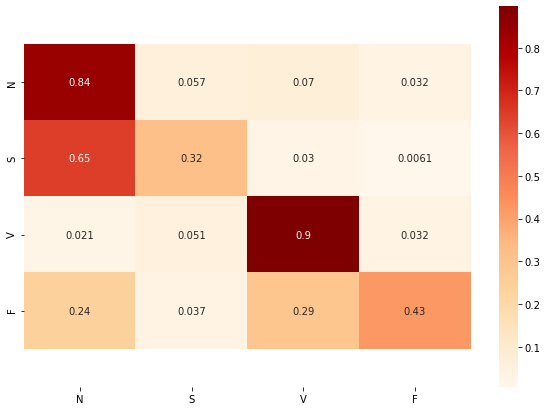

In [9]:
# Teste da rede
Y_train_preds0_cnn = model0.predict(X_train_CNN0, verbose = 0)
Y_test_preds0_cnn = model0.predict(X_test_CNN0, verbose = 0)
M0 = resultados(Y_train_int, np.argmax(Y_train_preds0_cnn, axis = 1), Y_test_int, np.argmax(Y_test_preds0_cnn, axis = 1), numclass)
metricasNSVF(M0, True, r'resultados_cnn.csv', 'CNN_modelo0', str(modo), str(periodo), '3-10-10-10', nepochs, key)

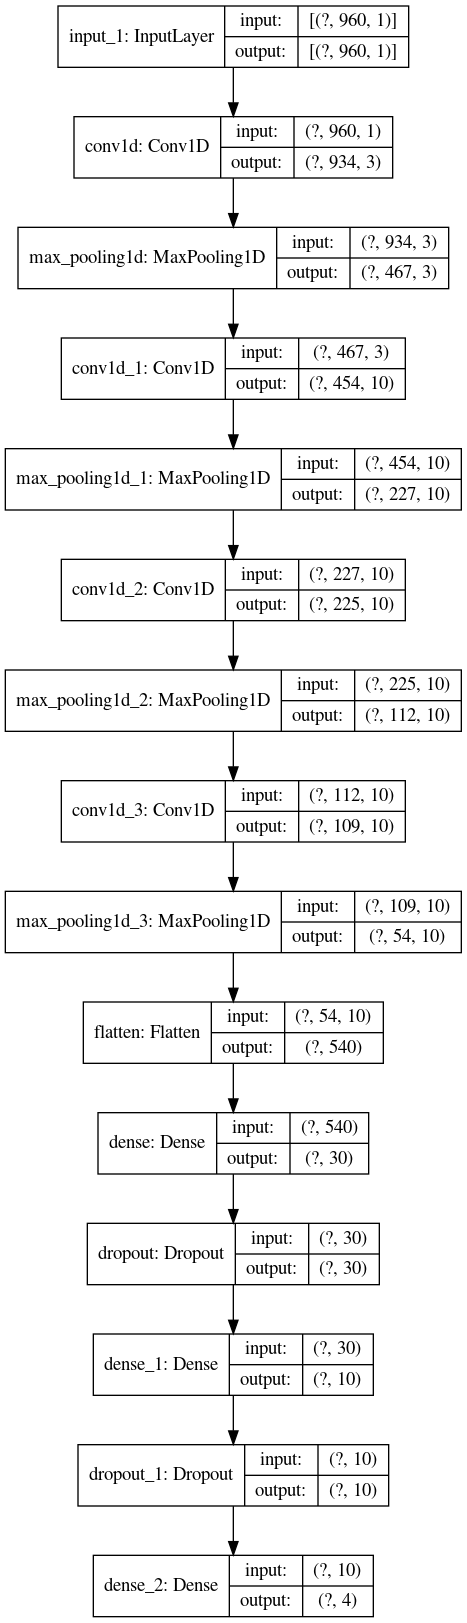

In [10]:
tf.keras.utils.plot_model(model0, to_file=key+'.png', show_shapes=True, expand_nested=False)

In [11]:
model0.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 960, 1)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 934, 3)            84        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 467, 3)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 454, 10)           430       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 227, 10)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 225, 10)           310       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 112, 10)          